In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys


# Build an Autoencoder for a human face dataset

We will use a dataset containig images of people and train an autoencoder on it. 

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [25]:
path = 'C:/Users/ralle/PycharmProjects/550-pattern_recognition/HW3/lfw/lfw'
#path = '../HW3/lfw'

In [26]:
transform    = transforms.Compose([transforms.ToTensor()]) 
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)


This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [27]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print ("MPS device not found.")


MPS device not found.


torch.Size([32, 3, 250, 250])
torch.Size([250, 250, 3])


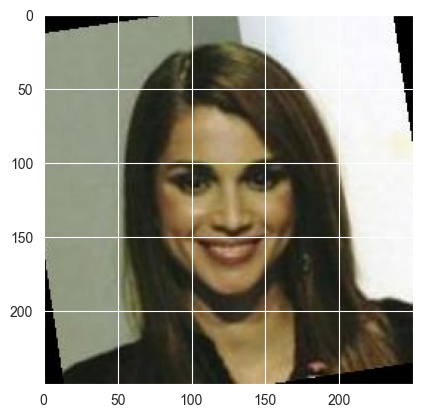

In [34]:
for x,y in dataloader:
    print(x.shape)
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

## Step 2
Each datapoint is an image. Get a sample of the data and print its dimensions and explain what each dimension means.

# Step 3

Create a new pytorch model calss for your autoencoder. You can use Conv2d, MaxPool2d, BatchNorm2d, ConvTranspose2d and Linear Layers as as well as activation functions. Optionally, you can use UpSample, AveragePool2d and Interpolate2d as well.

**Create seperate functions for the encoder and decoder.**

In [75]:
class AE(nn.Module):
    
    def __init__(self):
        super(AE,self).__init__()
        self.encoder = nn.Sequential( ## use conv layers to downscale the input
            nn.Conv2d(3, 32, 4, stride=2, padding=1), # b, 32, 125, 125
            nn.ReLU(True),
            nn.MaxPool2d(3, stride=2), # b, 32, 62, 62
            nn.Conv2d(32, 16, 2, stride=2, padding=1), # b, 16, 32, 32
            nn.ReLU(True),
            nn.MaxPool2d(5, stride=3) # b, 16, 10, 10
        )
        
        self.decoder = nn.Sequential( ## use convTranspose layers to upscale the input back to it original shape
            nn.ConvTranspose2d(16, 32, kernel_size=5, stride=2, padding=1),  # b, 32, 21, 21
            nn.ReLU(),
            nn.ConvTranspose2d(32, 64, kernel_size=5, stride=2, padding=1),  # b, 64, 45, 45
            nn.ReLU(),
            nn.ConvTranspose2d(64, 128, kernel_size=5, stride=2, padding=1),  # b, 128, 93, 93
            nn.ReLU(),
            nn.ConvTranspose2d(128, 3, kernel_size=5, stride=2, padding=1),    # b, 3, 189, 189
            nn.Upsample((250, 250), mode='bilinear', align_corners=False)    # Upsample to original size
            )

    def encode(self,x): ##this was probably not what was meant with seperate functions for encoder/decoder, but I cant find any class material or help online on how to get trainable parameters from the model if it is implemented inside the method.
        return self.encoder(x)
        
    def decode(self,x): #same as comment for encode
        return self.decoder(x)
        
        
    def forward(self,x):
        encoder_output = self.encoder(x)
        decoder_output = self.decoder(encoder_output)
        return decoder_output
        
        

## Step 4
Create an instance of the class, pass an image to the model, print the shape of the output of the **encoder** and the **decoder**. Check the dimensions and make sure your forward path is working properly.

In [76]:
model = AE()

for x,y in dataloader:
    #x = x[0].permute(1, 2, 0)
    print("Shape before: " + str(x.shape))
    output = model.encode(x)
    print("Shape of encoder output: " + str(output.shape))
    output = model.decode(output)
    print("Shape of decoder output: " + str(output.shape))   
    
    model_output = model.forward(x)
    
    assert model_output.shape == output.shape ## sanity check to see if shape of forward method is correct
    
    break

Shape before: torch.Size([32, 3, 250, 250])
Shape of encoder output: torch.Size([32, 16, 10, 10])
Shape of decoder output: torch.Size([32, 3, 250, 250])


##  Step 5
Print total number of parameters in the model, explain what loss function you should use, create an optimizer for training

In [77]:
optim = torch.optim.Adam(model.parameters(), lr=0.01) ## This is not the best reason. But from my adv. AI class I learned that generally Adam optimizer is just better than other alternatives

In [78]:
loss_function = nn.MSELoss() ## I chose MSE as it is a good way of calculating the reconstruction loss. Whereas other loss functions such as categorical-cross-entropy would fit better for stuff like classification

##  Step 6
Write a training loop and start trainng the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

In [ ]:
epochs = 8

for epoch in range(epochs):
    model.train()
    loss_history = []
    cumulated_loss = 0.0
    
    for x, _ in dataloader: #y not needed as the target in autoencoders is the input
        optim.zero_grad() ##Needed to reset gradients
        
        predicted_output = model(x)
        loss = loss_function(predicted_output, x)
        cumulated_loss += loss.data.item()
        
        loss.backward()
        optim.step()
        
    print(f"Epoch {epoch+1}: Loss= {round(cumulated_loss / len(dataloader), 4)}")

In [ ]:
##Several things can be done in order to troubleshoot. One thing is trying to change the learning_rate, other things can be trying to introduce regularization techniques such as dropout and batchnorm in order to avoid overfitting.

##  Step 7

Take a random image from the dataset and plot it against the reconstructed (encoded + decoded) image.

In [ ]:
##Since the images are shuffled when creating the dataloader, ill take the first image from the dataset and plot it
random_image = None

for x,_ in dataloader:
    random_image = x
    break

encoder_output = model.encode(random_image) ##needed for step 8
predicted_image = model.decode(encoder_output)

plt.imshow(predicted_image[0].permute(1, 2, 0))

In [ ]:
plt.imshow(random_image[0].permute(1, 2, 0))

##  Step 8

In step 7, add a small normaly distrubuted noise to the latent (hidden) representation of the input image and then decode it again. How is adding noise affecting the decoded image ?